<a href="https://colab.research.google.com/github/DataSciWithJoshua/Shallow-Neural-Networks/blob/main/Homework1_JJ_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Name

## Setup

#### Imports

In [ ]:
import os
import time
from pathlib import Path
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from torch.nn.utils.rnn import pad_sequence
from torchinfo import summary
from sklearn.metrics import f1_score, confusion_matrix

ModuleNotFoundError: No module named 'Adam'

### Connecting to colab drive or local file system for persistent storage

In [3]:
try:
    # if this fails, we are not running in a colab environment
    from google.colab import drive
    exec_env = "colab"
except ImportError:
    exec_env = "local"


match exec_env:
    case "colab":
        print("Running in Google Colab")
        drive.mount('/content/drive')
        drive_path = "/content/drive/My Drive/"
    case "local":
        print("Running locally")
        drive_path = "" # make sure this is a local valid drive path
    case _:
        print("Unknown execution environment")


Running locally


### Helper Functions

In [4]:
def display_metadata(dataset, msg="") -> None:
    """Displays size and range of various input types, used for debugging"""
    if isinstance(dataset, torch.utils.data.Dataset):
        sample, _ = dataset[0]
        print(f'{msg} Dataset Shape: {dataset.data.shape}, Raw Min-Max: {dataset.data.min()}-{dataset.data.max()}, Min-Max: {sample.min().item():0.2f}-{sample.max().item():0.2f}')
    elif isinstance(dataset, torch.Tensor):
        print(f'{msg} Tensor Shape: {dataset.shape}, Min-Max: {dataset.min().item():0.2f}-{dataset.max().item():0.2f}')
    elif isinstance(dataset, list):
        print(f'{msg}   List Shape: {len(dataset)}, Min-Max: {min(dataset):0.2f}-{max(dataset):0.2f}')
    else:
        print(f"{msg} Unsupported type for metadata display: {type(dataset)}")

### Setup graphics processor if available

In [5]:
def device_setup() -> torch.DeviceObjType:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA is available. Training on GPU.")
    
    elif torch.backends.mps.is_available():
        torch.backends.mps.benchmark = True
        device = torch.device("mps")
        print("MPS is available. Training with MPS.")
    
    else:
        device = torch.device("cpu")
        print("CUDA is not available. Training on CPU.")

    return device

## Class Balancing with Weighted Sampling

### Data Load

In [140]:

# Convert to tensor, normalize to [-1,1]
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.ImageFolder(root=r"fruits-360/Training", transform=transform)
test_dataset  = datasets.ImageFolder(root=r"fruits-360/Test", transform=transform)

# Split into train and validation sets
train_ratio = 0.8 
val_ratio   = 0.2 
total_samples = len(train_dataset)
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Count occurrences of each class in the train_subset
train_targets = [train_dataset.targets[idx] for idx in train_subset.indices]
val_targets   = [train_dataset.targets[idx] for idx in   val_subset.indices]

# Create class-to-index mappings
class_counts = Counter(train_targets)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Count # of samples for each class
for class_idx, count in class_counts.items():
    print(f"Class: ({class_idx:003}) {idx_to_class[class_idx].ljust(21)}  - Samples: {count}")

num_samples = len(train_subset)
class_weights  = {class_idx: num_samples / count for class_idx, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_targets]

# Display Class Weights
# for class_idx, weight in class_weights.items():
#     print(f"Class Weights: ({class_idx:003}) {idx_to_class[class_idx].ljust(21)}  - Weight: {weight:.2f}")

Class: (135) Tomato Yellow 1        - Samples: 361
Class: (032) Cherry Rainier 1       - Samples: 581
Class: (071) Mango 1                - Samples: 398
Class: (019) Banana Lady Finger 1   - Samples: 361
Class: (020) Banana Red 1           - Samples: 395
Class: (065) Kumquats 1             - Samples: 382
Class: (094) Pear Forelle 1         - Samples: 563
Class: (060) Hazelnut 1             - Samples: 365
Class: (126) Tamarillo 1            - Samples: 388
Class: (067) Lemon Meyer 1          - Samples: 410
Class: (046) Eggplant 1             - Samples: 375
Class: (050) Granadilla 1           - Samples: 395
Class: (122) Redcurrant 1           - Samples: 373
Class: (066) Lemon 1                - Samples: 388
Class: (096) Pear Monster 1         - Samples: 385
Class: (129) Tomato 2               - Samples: 545
Class: (092) Pear 3                 - Samples: 166
Class: (070) Mandarine 1            - Samples: 375
Class: (016) Avocado 1              - Samples: 356
Class: (091) Pear 2            

In [7]:
# Setup Dataloaders
batch_size = 64
device = device_setup()

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader     = DataLoader(train_subset, batch_size=batch_size,    shuffle=True, pin_memory=True, num_workers=4, persistent_workers=True)
train_loader_WRS = DataLoader(train_subset, batch_size=batch_size, sampler=sampler, pin_memory=True, num_workers=4, persistent_workers=True)
# train_loader_GAN = DataLoader(train_subset, batch_size=batch_size, sampler=sampler, pin_memory=True, num_workers=4, persistent_workers=True)

val_loader       = DataLoader(  val_subset, batch_size=batch_size,   shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)
test_loader      = DataLoader(test_dataset, batch_size=batch_size,   shuffle=False, pin_memory=True, num_workers=4, persistent_workers=True)

# Pre-allocated space on device
train_loader        = [(data[0].to(device), data[1].to(device)) for data in train_loader]
train_loader_WRS    = [(data[0].to(device), data[1].to(device)) for data in train_loader_WRS]

val_loader = [(data[0].to(device), data[1].to(device)) for data in val_loader]
test_loader = [(data[0].to(device), data[1].to(device)) for data in test_loader]


# Verify balanced sampling
balanced_counts = Counter()
for _, labels in train_loader_WRS:
    balanced_counts.update(labels.tolist())

# Display Rebalanced Samples
for class_idx, count in balanced_counts.items():
    print(f"Balanced Class: ({class_idx:003}) {idx_to_class[class_idx].ljust(21)}  - Samples: {count}")

MPS is available. Training with MPS.
Balanced Class: (069) Lychee 1               - Samples: 381
Balanced Class: (112) Plum 3                 - Samples: 407
Balanced Class: (101) Pepper Green 1         - Samples: 422
Balanced Class: (024) Cactus fruit 1         - Samples: 422
Balanced Class: (083) Onion White 1          - Samples: 394
Balanced Class: (029) Cauliflower 1          - Samples: 440
Balanced Class: (013) Apple Red Yellow 2     - Samples: 411
Balanced Class: (032) Cherry Rainier 1       - Samples: 394
Balanced Class: (110) Plum 1                 - Samples: 412
Balanced Class: (128) Tomato 1               - Samples: 413
Balanced Class: (068) Limes 1                - Samples: 390
Balanced Class: (109) Pitahaya Red 1         - Samples: 394
Balanced Class: (106) Physalis with Husk 1   - Samples: 394
Balanced Class: (074) Maracuja 1             - Samples: 385
Balanced Class: (022) Blueberry 1            - Samples: 409
Balanced Class: (085) Papaya 1               - Samples: 449
Bal

images Tensor Shape: torch.Size([64, 3, 64, 64]), Min-Max: -1.00-1.00
labels Tensor Shape: torch.Size([64]), Min-Max: 3.00-138.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..1.0].


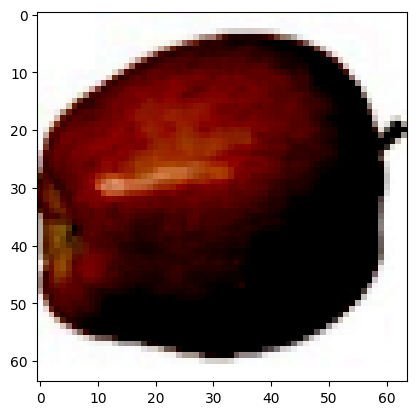

In [8]:
# Get the first batch of images from the dataloader  
for images, labels in train_loader:
    images, labels = images.cpu(), labels.cpu()
    display_metadata(images,msg='images')
    display_metadata(labels,msg='labels')
    
    # Select the first image in the batch  
    image = images[0]  
  
    # Convert the PyTorch tensor to a numpy array  
    image = np.transpose(image.numpy(), (1, 2, 0))  
    
    # Plot the image  
    plt.imshow(image)  
    plt.show()  
    break

### Display Data Distribution 

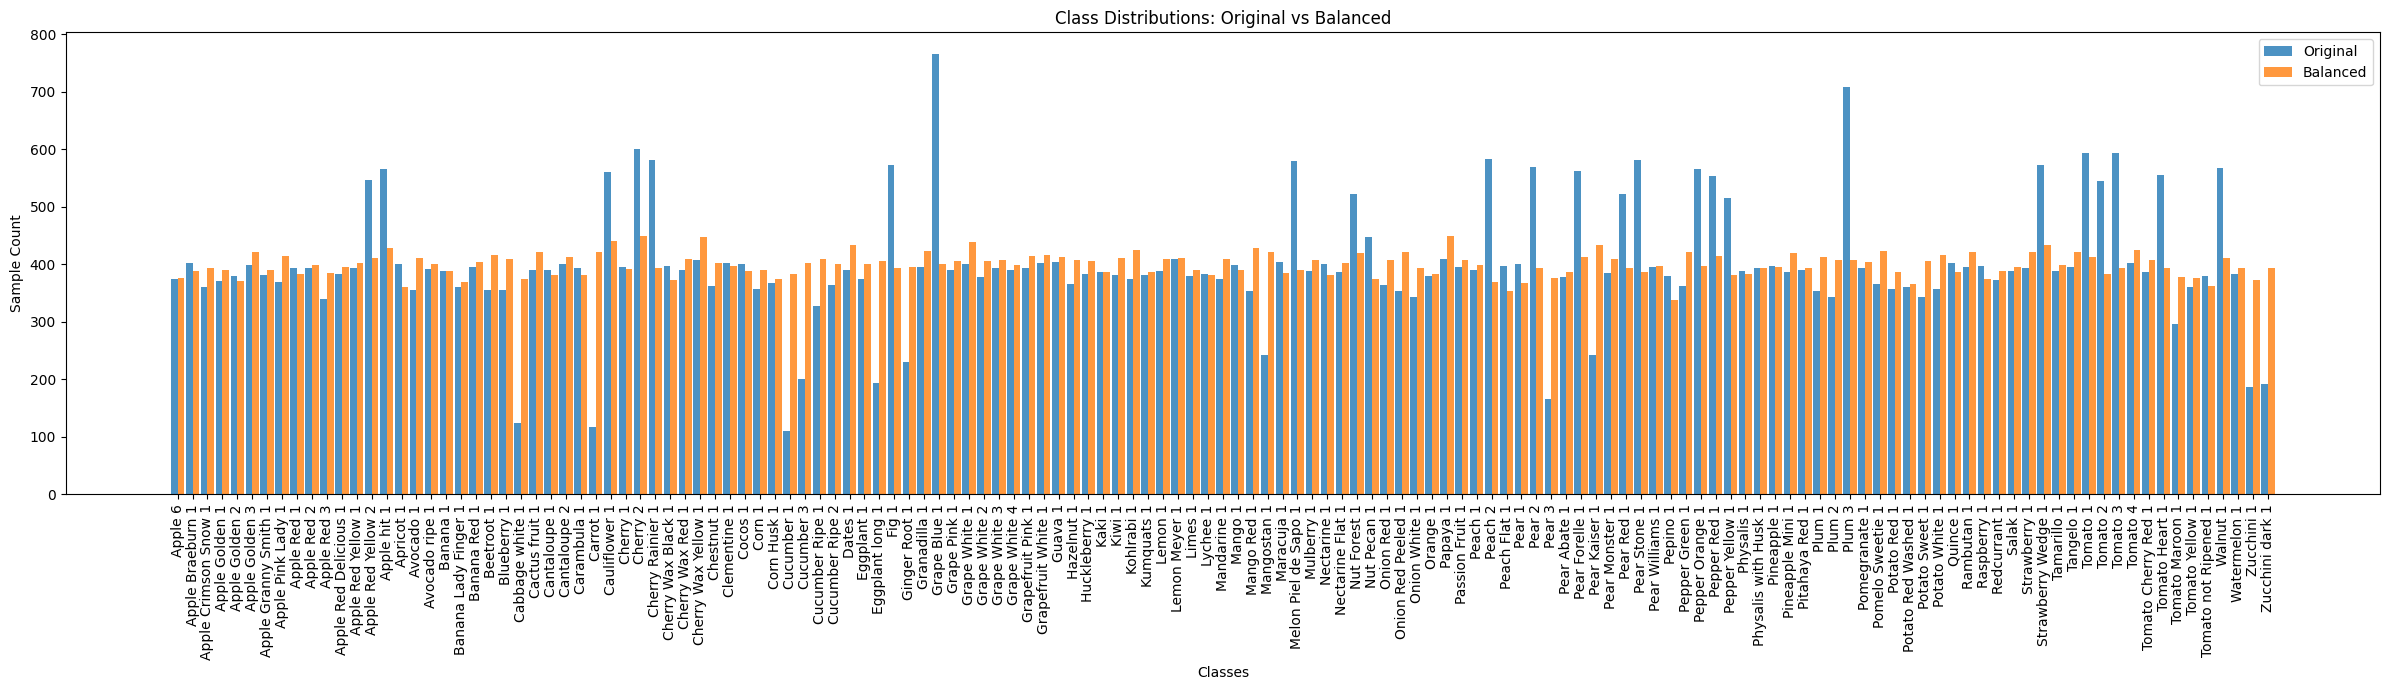

In [143]:
def plot_class_distributions(class_counts, balanced_counts, idx_to_class):
    
    # Extract class names and counts
    sorted_classes = sorted(class_counts.keys())
    class_names     = [idx_to_class[class_idx] for class_idx in sorted_classes]
    original_counts = [class_counts[class_idx] for class_idx in sorted_classes]
    balanced_counts = [balanced_counts.get(class_idx, 0) for class_idx in sorted_classes]

    # Plot the histograms
    bar_width = 0.45
    x_positions = np.arange(len(sorted_classes))
    plt.figure(figsize=(24, 7))
    plt.bar(x_positions - bar_width / 2, original_counts, width=bar_width, label='Original', alpha=0.8)
    plt.bar(x_positions + bar_width / 2, balanced_counts, width=bar_width, label='Balanced', alpha=0.8)
    plt.xticks(ticks=x_positions, labels=class_names, rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Sample Count')
    plt.title('Class Distributions: Original vs Balanced')
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_class_distributions(class_counts, balanced_counts, idx_to_class)



### Define Baseline Network

In [10]:
from torch.nn import Sequential, Conv2d, MaxPool2d, BatchNorm2d, Flatten, Linear, Dropout, Softmax, init, ReLU, LeakyReLU, Tanh


class BaselineCNN(nn.Module):
    def __init__(self, activation, img_size:int, dropout:int, init_method="xavier", num_classes=141):
        super(BaselineCNN, self).__init__()

        self.img_size = img_size

        # Input channels = 3 (RGB), output channels = 32 (k features)
        final_channel_size = 16
        self.layers = Sequential(
            Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
            activation(), 
            BatchNorm2d(32), 
            MaxPool2d((2, 2)),
            
            Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1),
            activation(), 
            BatchNorm2d(32), 
            MaxPool2d((2, 2)),

            Conv2d(32, final_channel_size, kernel_size=(3, 3), stride=1, padding=1),
            activation(), 
            BatchNorm2d(final_channel_size), 
            MaxPool2d((2, 2)),

            Flatten(),

            # Downsample input by pool size (2) ^ # of Conv2d layers (3) = 8
            Linear((self.img_size//8)**2 * final_channel_size, 32), 
            activation(), 
            Dropout(dropout),
            
            Linear(32, num_classes), 
            Softmax(dim=1),
        )                               

        if init_method == "normal":
            for layer in self.layers:
                if isinstance(layer, Linear):
                    init.normal_(layer.weight, mean=0, std=0.01)
        elif init_method == "xavier":
            for layer in self.layers:
                if isinstance(layer, Linear):
                    init.xavier_uniform_(layer.weight)
        elif init_method == "kaiming":
            for layer in self.layers:
                if isinstance(layer, Linear):
                    init.kaiming_uniform_(layer.weight, nonlinearity='relu')

    def forward(self, x):
        return self.layers(x)


    def check_layer_dimensions(self, batch_size=1, channels=1):
        x = torch.randn((batch_size, channels, self.img_size, self.img_size))  # Create a dummy input
        for i, layer in enumerate(self.layers):
            print(str(x.shape).ljust(28), layer)
            try:
                x = layer(x)  # Pass the dummy input through the layer
            except:
                raise ValueError(f"Dimension mismatch at layer {i}: {layer}")
            
        print("All dimensions are consistent!")


model_checkout = BaselineCNN(activation=ReLU, img_size=64, dropout=0.1)
model_checkout.check_layer_dimensions(batch_size=1, channels=3)

torch.Size([1, 3, 64, 64])   Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 32, 64, 64])  ReLU()
torch.Size([1, 32, 64, 64])  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 32, 64, 64])  MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 32, 32, 32])  Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 32, 32, 32])  ReLU()
torch.Size([1, 32, 32, 32])  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 32, 32, 32])  MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 32, 16, 16])  Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 16, 16, 16])  ReLU()
torch.Size([1, 16, 16, 16])  BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
torch.Size([1, 16, 16, 16])  MaxPool2d(kernel_size=(2

### Network Training

In [11]:
def train_and_test_cnn(model,train_loader:DataLoader,test_loader:DataLoader,num_epochs:int, loss_func,optimizer_func) -> dict:
    start_time = time.time()

    train_acc = []
    test_acc = []
    train_loss = []

    best_accuracy = 0
    epochs_without_improvement = 0
    epochs_without_improvement_limit = 5
    stopped_early = False

    # Monitor gradient fluctuation using the formula g = lr * N / B
    # grad_fluctuation = monitor_grad_fluctuation(optimizer_func, batch_size, total_samples=2459)
    # print(f'Gradient fluctuation (g): {grad_fluctuation:.5f}')

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_test = 0
        total_test = 0

        # Train Model
        model.train()
        for i, (train_input, train_labels) in enumerate(train_loader):
            # train_input, train_labels = train_input.to(device), train_labels.to(device)
        
            # Forward pass
            outputs_train = model(train_input)
            loss = loss_func(outputs_train, train_labels)
            running_loss += loss.item()

            # Backward pass
            optimizer_func.zero_grad() 
            loss.backward()
            optimizer_func.step()

            # Compute accuracy
            _, predicted_train = torch.max(outputs_train, 1)
            correct_train += (predicted_train == train_labels).sum().item()
            total_train += train_labels.size(0)

       
        # Test Model
        model.eval()
        with torch.inference_mode():
            for i, (input, test_labels) in enumerate(test_loader):
                # input, test_labels = input.to(device), test_labels.to(device)

                # Forward pass
                outputs_test = model(input) 
                
                # Compute accuracy
                _, predicted_test = torch.max(outputs_test, 1)
                correct_test += (predicted_test == test_labels).sum().item()
                total_test += test_labels.size(0)
        

        # Average Train and Test Accuracy
        train_accuracy = correct_train / total_train
        test_accuracy  = correct_test  / total_train

        # Log loss and accuracy
        epoch_loss = running_loss / len(train_loader)
        train_loss.append(epoch_loss)
        
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)

        # Display accuracy and timing per epoch
        epoch_time = time.time() - epoch_start_time

        print(
            f'Epoch [{epoch+1:03}/{num_epochs}], \
                Train Loss: {epoch_loss:.6f}, \
                Train Acc: {train_accuracy:02.2f}, \
                Test Acc: {test_accuracy:02.2f}, \
                Epoch Time: {epoch_time:.2f}'
        )

        # Early stop check - if a given number of epochs run without improvement in accuracy, stop training
        if test_accuracy > best_accuracy:
            # Validation Accuracy improved
            best_accuracy = test_accuracy
            epochs_without_improvement = 0
            best_model_state = model.state_dict()
        else:
            # Validation Accuracy has not improved
            epochs_without_improvement += 1

        # Stop Training
        if epochs_without_improvement >= epochs_without_improvement_limit:
            print(f"Early Stopping triggered after {epoch+1} epochs. Best Test Acc: {best_accuracy:.2f}")
            stopped_early = True
            break

    # Load the state from the best model seen if early stopping was triggered
    if stopped_early:
        model.load_state_dict(best_model_state)

    print(f'Total Time: {(time.time()-start_time):.2f}')

    results = {
        "train_acc":train_acc,
        "test_acc":test_acc,
        "train_loss":train_loss,
        "model":model,
    }

    return results

### Run Model

In [127]:
def save_results(results:dict, save_dir:Path):
    for attr_name,attr in results.items():
        full_stem_path = Path(f'{save_dir}/{attr_name}')
        
        # Accuracy and Loss
        if isinstance(attr, list):
            np.save(full_stem_path.with_suffix('.npy'),  np.array(attr))
    
        # PyTorch Model
        elif isinstance(attr, nn.Module):
            torch.save(attr.state_dict(), full_stem_path.with_suffix('.pt'))

        else:
            raise TypeError(f"Unexpected type, {attr_name} not saved")
            
        print(f'Data saved to disk: {full_stem_path}')


def save_torch_summary(model, model_name, input_size):
    torch_summary = summary(model,
                    input_size=input_size,
                    col_names=["input_size","output_size","num_params","trainable"],
                    col_width=20,
                    row_settings=["var_names"],
                   )

    # Convert to dataframe
    rows = []
    table_name = ""
    for i,layer in enumerate(torch_summary.summary_list):
        layer_name = str(layer).split(':')[0]
        if i==0: # skip model name
            table_name=layer_name
            continue
        if layer_name == 'Sequential': # skip sequential, redundant info
            continue
        rows.append({
            "Layer (type)": layer_name,
            "Input Shape": layer.input_size,
            "Output Shape": layer.output_size,
            "Param #": layer.num_params,
            "Trainable": layer.trainable,
        })

    df = pd.DataFrame(rows)

    # Create a table plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis("tight")
    ax.axis("off")
    tbl = pd.plotting.table(ax, df, loc="center", colWidths=[0.2] * len(df.columns))
    ax.set_title(table_name, fontsize=16)
    tbl.scale(1.2, 1.2)

    # Save as image
    plt.savefig(f"{model_name}.png", dpi=300, bbox_inches="tight")
    print(f"Summary saved as {model_name}.png")

Summary saved as baseline_2d_CNN.png


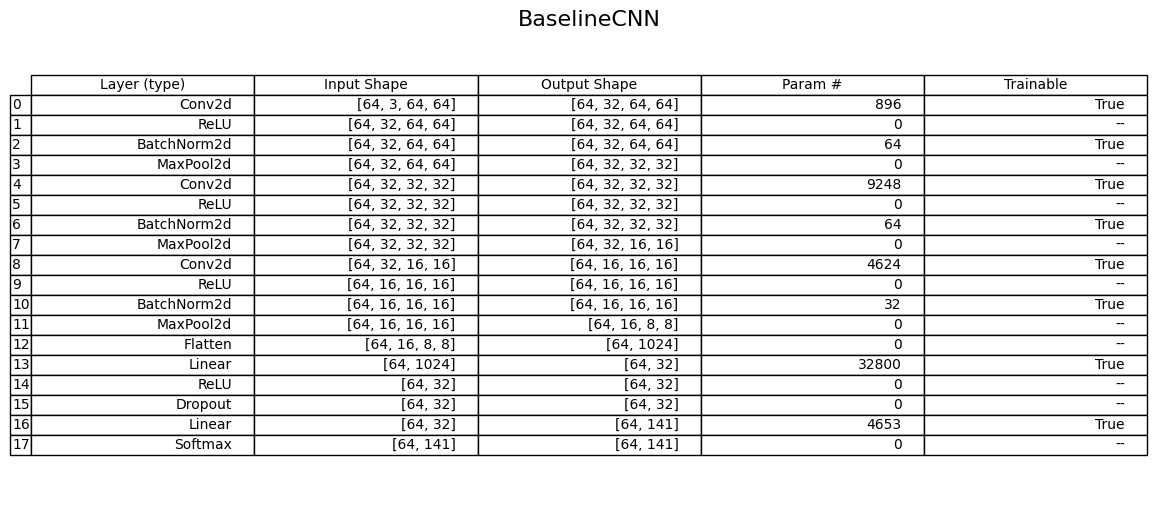

In [126]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

learning_rate = 0.001
num_epochs = 20
img_size = 64
dropout = 0.2
DEBUG=False

# Check Path
experiment = "class_balancing"
model_description = "baseline_2d_CNN"
save_dir = Path(f'{os.getcwd()}/{experiment}/{model_description}')
save_dir.mkdir(parents=True, exist_ok=True)
assert save_dir.exists(),f'Path to Save directory is not valid:\n{save_dir}' 


model_a = BaselineCNN(activation=ReLU, img_size=img_size, dropout=dropout)
model_batch = {
    model_a: model_description,
    # BaselineCNN(activation=Tanh, img_size=img_size, dropout=dropout): model_description,
    # BaselineCNN(activation=LeakyReLU, img_size=img_size, dropout=dropout): model_description,
}

save_torch_summary(model=model_a, model_name=model_description, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
# Run Batch of Networks
for model,desc in model_batch.items():

    # Choose loss func and optimizer
    loss_func = CrossEntropyLoss()
    optimizer_func = Adam(model.parameters(), lr=learning_rate)

    print(f'\nRunning {desc}\n')
    model = model.to(device)

    # Train and Test
    results = \
        train_and_test_cnn(
            model=model, 
            train_loader=train_loader, 
            test_loader=val_loader, 
            num_epochs=num_epochs,
            loss_func=loss_func,
            optimizer_func=optimizer_func,
        )

    save_results(results, save_dir)

### Load Model

In [130]:
def load_results(load_dir: Path, model_class=None, device="cpu") -> dict:
    results = {}
    
    for file_path in load_dir.iterdir():
        attr_name = file_path.stem
        ext = file_path.suffix
        
        # Load loss or accuracy arrays
        if ext == ".npy":
            results[attr_name] = np.load(file_path, allow_pickle=True).tolist()
        
        # Load torch model
        elif ext == ".pt":
            if model_class is None:
                raise ValueError(f"Cannot load {file_path} without a model class.")
            
            # Load PyTorch model
            model = model_class
            model.load_state_dict(torch.load(file_path, weights_only=False, map_location=device))
            results[attr_name] = model
        else:
            raise TypeError(f"Unexpected file type: {file_path}")
        
        print(f"Data loaded from disk: {file_path}")
    
    return results



experiment = "class_balancing"
model_description = "baseline_2d_CNN"
load_dir = Path(f'{os.getcwd()}/{experiment}/{model_description}')

model_class = BaselineCNN(activation=ReLU, img_size=img_size, dropout=dropout)
loaded_results = load_results(load_dir, model_class=model_class, device=device)
loaded_model = loaded_results["model"].to(device)
print(loaded_results.keys())

Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/baseline_2d_CNN/model.pt
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/baseline_2d_CNN/train_loss.npy
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/baseline_2d_CNN/train_acc.npy
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/baseline_2d_CNN/test_acc.npy
dict_keys(['model', 'train_loss', 'train_acc', 'test_acc'])


### Test Model 

F1 Weighted Score: 42.15%
F1 Macro    Score: 41.48%


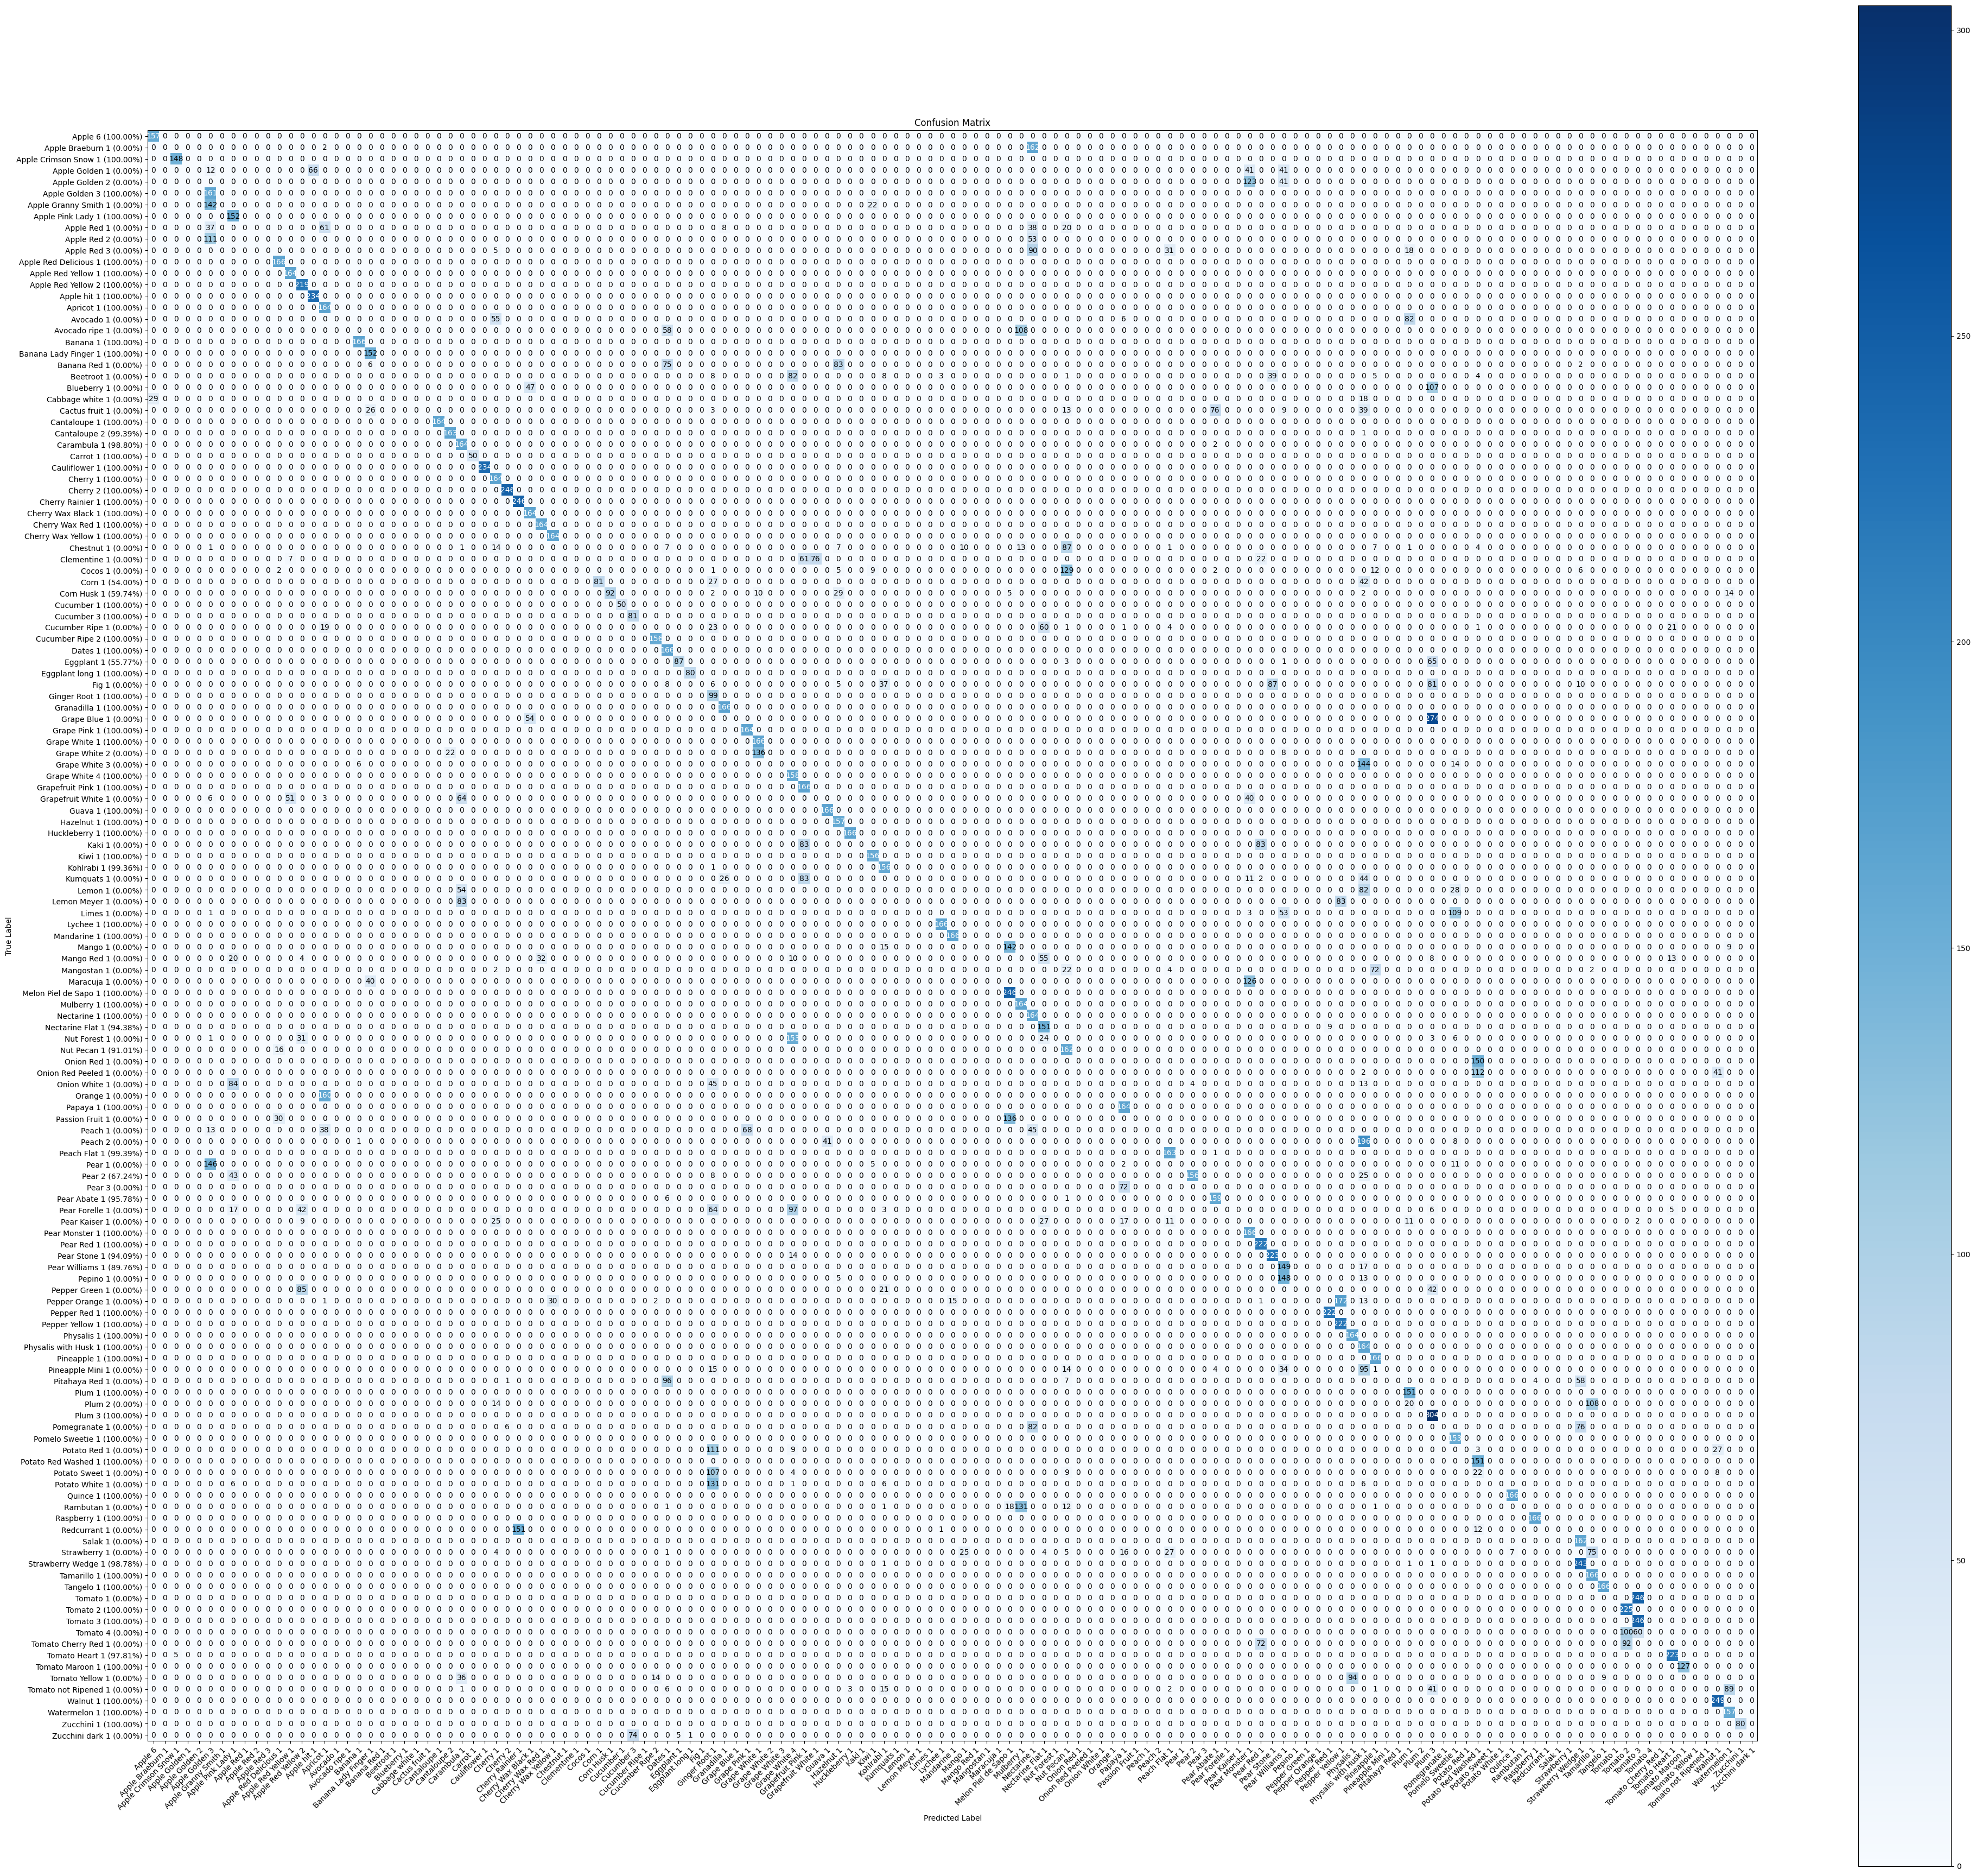

In [154]:
def evaluate_f1_score(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            
            # Forward Pass
            outputs = model(inputs)
            
            # Collect predictions and labels
            _, preds = torch.max(outputs, 1)  
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1_weighted  = f1_score(all_labels, all_preds, average='weighted')    
    f1_macro     = f1_score(all_labels, all_preds, average='macro')    
    
    return f1_weighted, f1_macro, all_labels, all_preds



def plot_confusion_matrix_with_accuracy(cm, class_names=None, figure_size=(8, 8), title="Confusion Matrix"):
    # Calculate per-class accuracy
    correct_preds = np.diag(cm)
    total_preds = cm.sum(axis=1)
    per_class_accuracy = correct_preds / total_preds
    accuracy_text = [f"{acc:.2%}" for acc in per_class_accuracy]


    # Display the matrix
    fig, ax = plt.subplots(figsize=figure_size)
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar(im, ax=ax)

    # Add labels and title
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(cm))]
    ax.set(xticks=np.arange(len(class_names)),
           yticks=np.arange(len(class_names)),
           xticklabels=class_names,
           yticklabels=[f"{name} ({acc})" for name, acc in zip(class_names, accuracy_text)],
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')

    # Rotate the tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations for confusion matrix values
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


# Determine F1 Scores
f1_weighted, f1_macro, all_labels, all_preds = evaluate_f1_score(loaded_model, test_loader, device)
print(f"F1 Weighted Score: {f1_weighted * 100:.2f}%")
print(f"F1 Macro    Score: {f1_macro    * 100:.2f}%")

# Plot Confusion Matrix
num_classes = 141
class_names = [idx_to_class[i] for i in range(num_classes)]
cm_baseline = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix_with_accuracy(cm_baseline, class_names=class_names, figure_size=(40, 35))



Class: (000) Apple 6               - Samples: 374
Class: (106) Physalis with Husk 1  - Samples: 394
Class: (023) Cabbage white 1       - Samples: 124
Avg # of Samples: 399


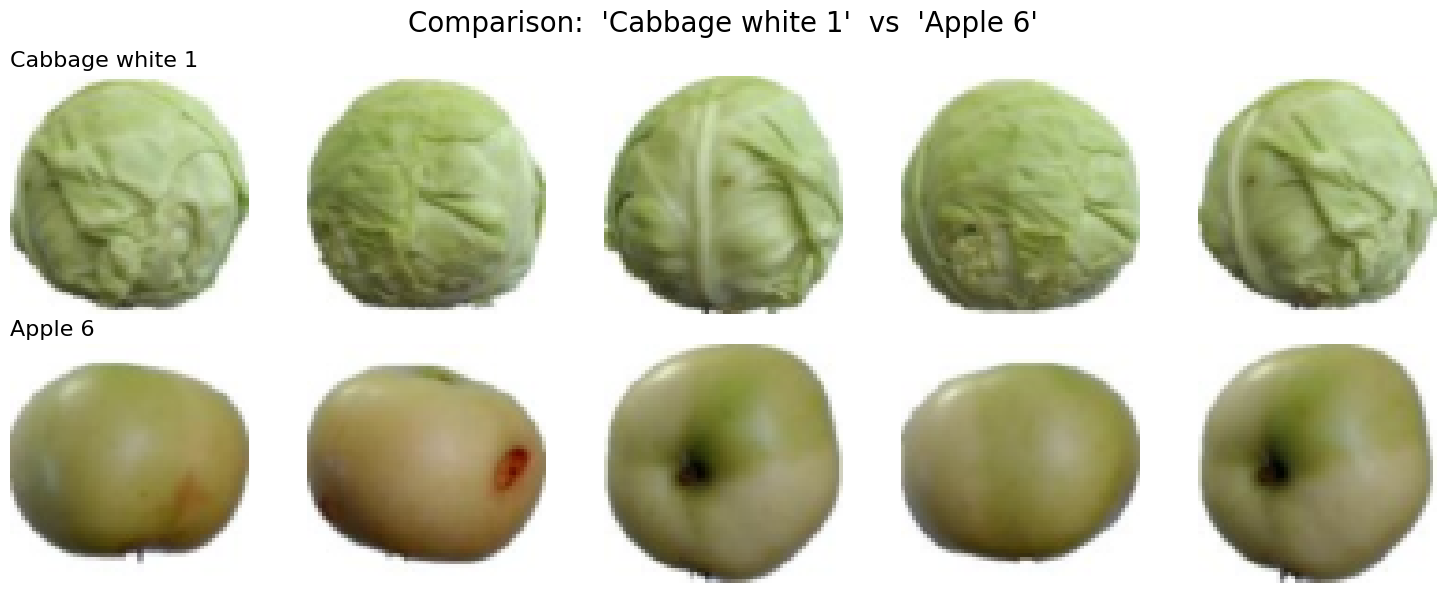

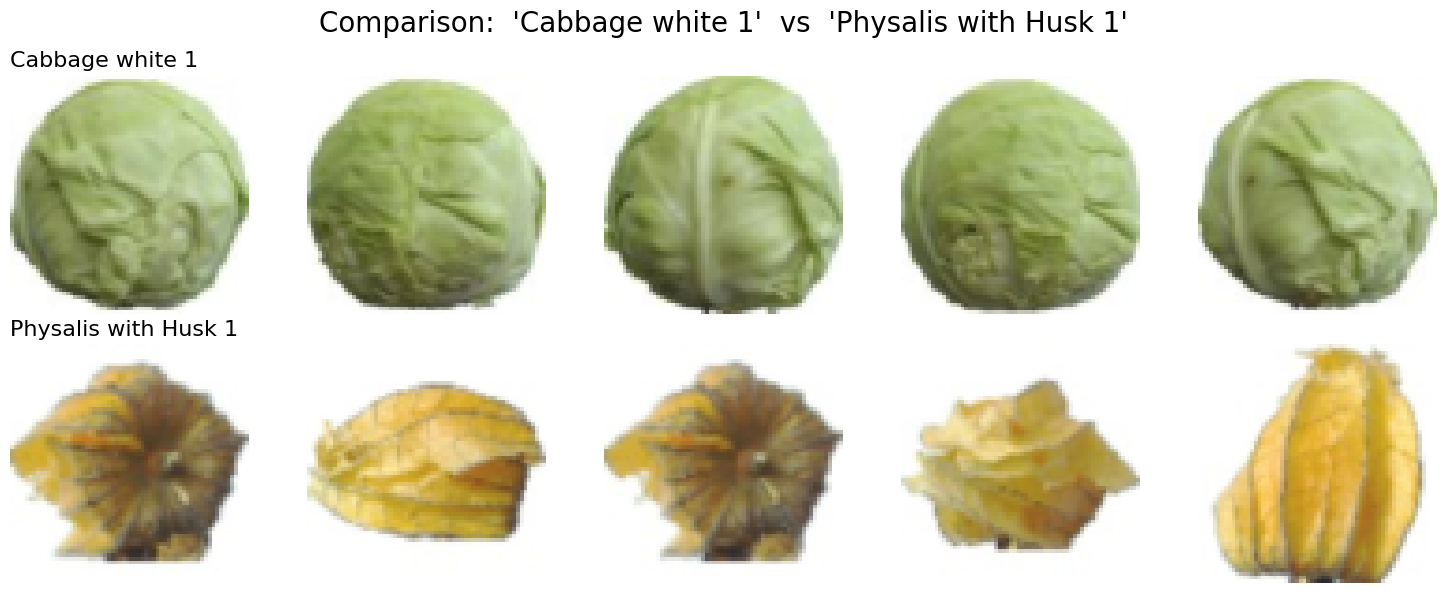

In [209]:
def reverse_transform(tensor, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  
    
    tensor = torch.clamp(tensor, 0, 1)
    
    return np.transpose(tensor.numpy(), (1, 2, 0))


def plot_class_comparison(train_loader, class_to_idx, class1, class2, num_samples=5):
    class1_id = class_to_idx[class1]
    class2_id = class_to_idx[class2]
    
    class1_samples = []
    class2_samples = []
    
    # Find num_samples instances of each class
    for images, labels in train_loader:
        images, labels = images.cpu(), labels.cpu()
        
        # Collect samples for class 1
        class1_indices = (labels == class1_id).nonzero(as_tuple=True)[0]
        for idx in class1_indices:
            if len(class1_samples) < num_samples:
                class1_samples.append(images[idx])
        
        # Collect samples for class 2
        class2_indices = (labels == class2_id).nonzero(as_tuple=True)[0]
        for idx in class2_indices:
            if len(class2_samples) < num_samples:
                class2_samples.append(images[idx])
        
        # Stop if we have enough samples
        if len(class1_samples) >= num_samples and len(class2_samples) >= num_samples:
            break

    # Verify enough samples are found
    if len(class1_samples) < num_samples or len(class2_samples) < num_samples:
        raise ValueError("Not enough samples found for one or both classes.")

    # Plot the samples
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    row_labels = [class1, class2]

    for row, (samples, label) in enumerate([(class1_samples, class1), (class2_samples, class2)]):
        for col in range(num_samples):
            # Reverse normalization
            img = reverse_transform(samples[col])
            
            # Plot image
            axes[row, col].imshow(img)
            axes[row, col].axis("off")
            
            # Set the Y-axis label only once per row (on the first column)
            if col == 0:
                axes[0, col].set_title(f"{class1}", fontsize=16, loc="left")
                axes[1, col].set_title(f"{class2}", fontsize=16, loc="left")
    
    # # Add overall labels
    plt.suptitle(f"Comparison:  '{class1}'  vs  '{class2}'", fontsize=20)
    plt.tight_layout()
    plt.show()


class1 = "Cabbage white 1"
class2 = "Apple 6"
class3 = "Physalis with Husk 1"

avg_samples = 0
# Count # of samples for each class
for class_idx, count in class_counts.items():
    class_name = idx_to_class[class_idx]
    avg_samples += count
    if class_name in [class1, class2, class3]:
        print(f"Class: ({class_idx:003}) {idx_to_class[class_idx].ljust(20)}  - Samples: {count}")

print(f"Avg # of Samples: {(avg_samples//num_classes):003}")


plot_class_comparison(train_loader, class_to_idx, class1, class2, num_samples=5)
plot_class_comparison(train_loader, class_to_idx, class1, class3, num_samples=5)

## Run WRS Class Balanced Data

In [136]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

learning_rate = 0.001
num_epochs = 20
img_size = 64
dropout = 0.2
DEBUG=False

# Check Path
experiment = "class_balancing"
model_description = "wrs_classbalanced_2d_CNN"
save_dir = Path(f'{os.getcwd()}/{experiment}/{model_description}')
save_dir.mkdir(parents=True, exist_ok=True)
assert save_dir.exists(),f'Path to Save directory is not valid:\n{save_dir}' 


model_a = BaselineCNN(activation=ReLU, img_size=img_size, dropout=dropout)
model_batch = {
    model_a: model_description,
}


In [ ]:
# Run Batch of Networks
for model,desc in model_batch.items():

    # Choose loss func and optimizer
    loss_func = CrossEntropyLoss()
    optimizer_func = Adam(model.parameters(), lr=learning_rate)

    print(f'\nRunning {desc}\n')
    model = model.to(device)

    # Train and Test
    results = \
        train_and_test_cnn(
            model=model, 
            train_loader=train_loader_WRS, 
            test_loader=val_loader, 
            num_epochs=num_epochs,
            loss_func=loss_func,
            optimizer_func=optimizer_func,
        )

    save_results(results, save_dir)

### Load Class balanced model

In [137]:
experiment = "class_balancing"
model_description = "wrs_classbalanced_2d_CNN"
load_dir = Path(f'{os.getcwd()}/{experiment}/{model_description}')

model_class = BaselineCNN(activation=ReLU, img_size=img_size, dropout=dropout)
loaded_results_wrs = load_results(load_dir, model_class=model_class, device=device)
loaded_model_wrs = loaded_results_wrs["model"].to(device)
print(loaded_results_wrs.keys())

Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/wrs_classbalanced_2d_CNN/model.pt
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/wrs_classbalanced_2d_CNN/train_loss.npy
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/wrs_classbalanced_2d_CNN/train_acc.npy
Data loaded from disk: /Users/joshuajones/Desktop/IU_Grad_School/Courses/ENGR_E_533/Homework/Repos/ENGR_E533_Project/class_balancing/wrs_classbalanced_2d_CNN/test_acc.npy
dict_keys(['model', 'train_loss', 'train_acc', 'test_acc'])


#### Test Model

F1 Weighted Score: 43.47%
F1 Macro    Score: 44.97%


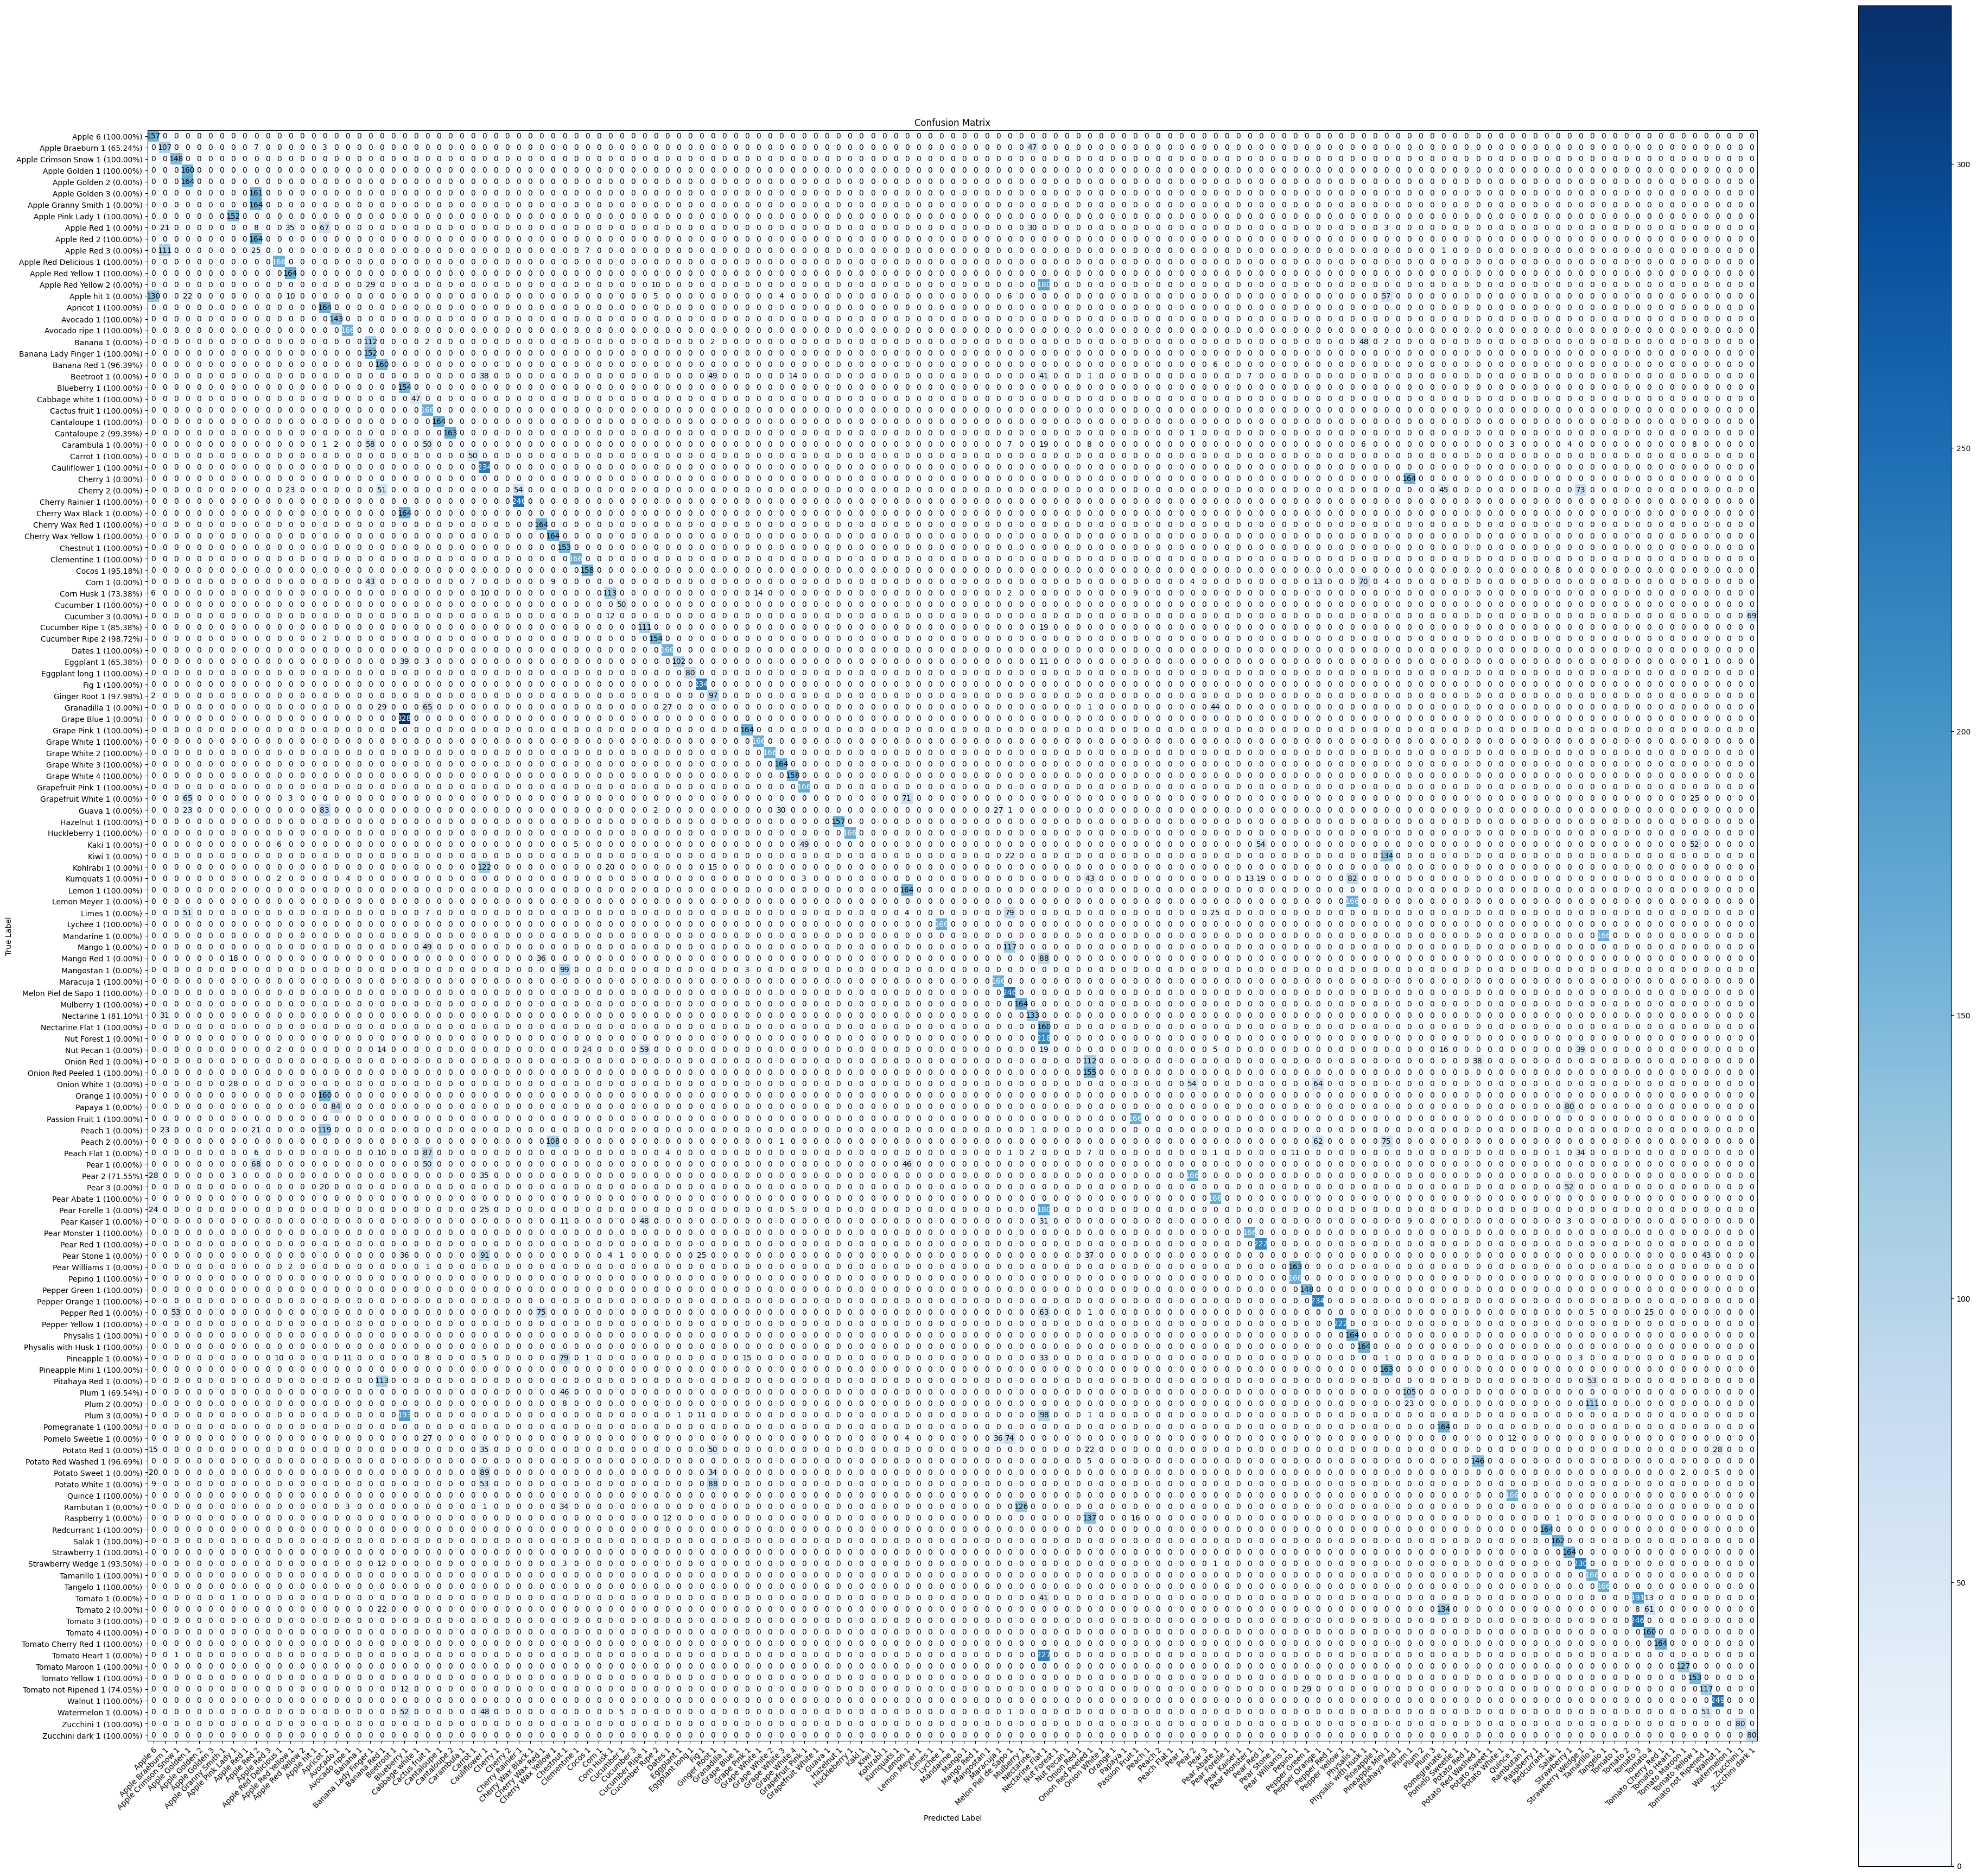

In [155]:
# Determine F1 Scores
f1_weighted, f1_macro, all_labels, all_preds = evaluate_f1_score(loaded_model_wrs, test_loader, device)
print(f"F1 Weighted Score: {f1_weighted * 100:.2f}%")
print(f"F1 Macro    Score: {f1_macro    * 100:.2f}%")

# Plot Confusion Matrix
num_classes = 141
class_names = [idx_to_class[i] for i in range(num_classes)]
cm_balanced = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix_with_accuracy(cm_balanced, class_names=class_names, figure_size=(40, 35))

Class: (106) Physalis with Husk 1  - Original Samples: 394 - Balanced Samples: 394
Class: (023) Cabbage white 1       - Original Samples: 124 - Balanced Samples: 374
Class: (000) Apple 6               - Original Samples: 374 - Balanced Samples: 376
Avg # of Samples: 399


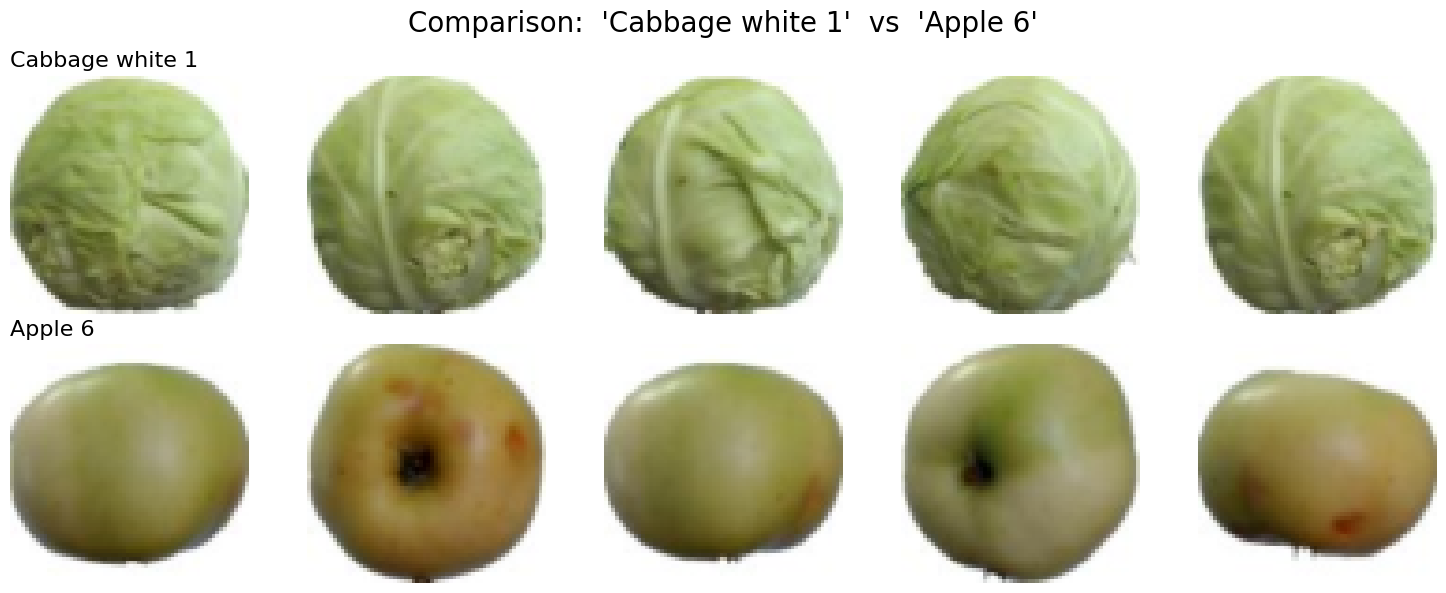

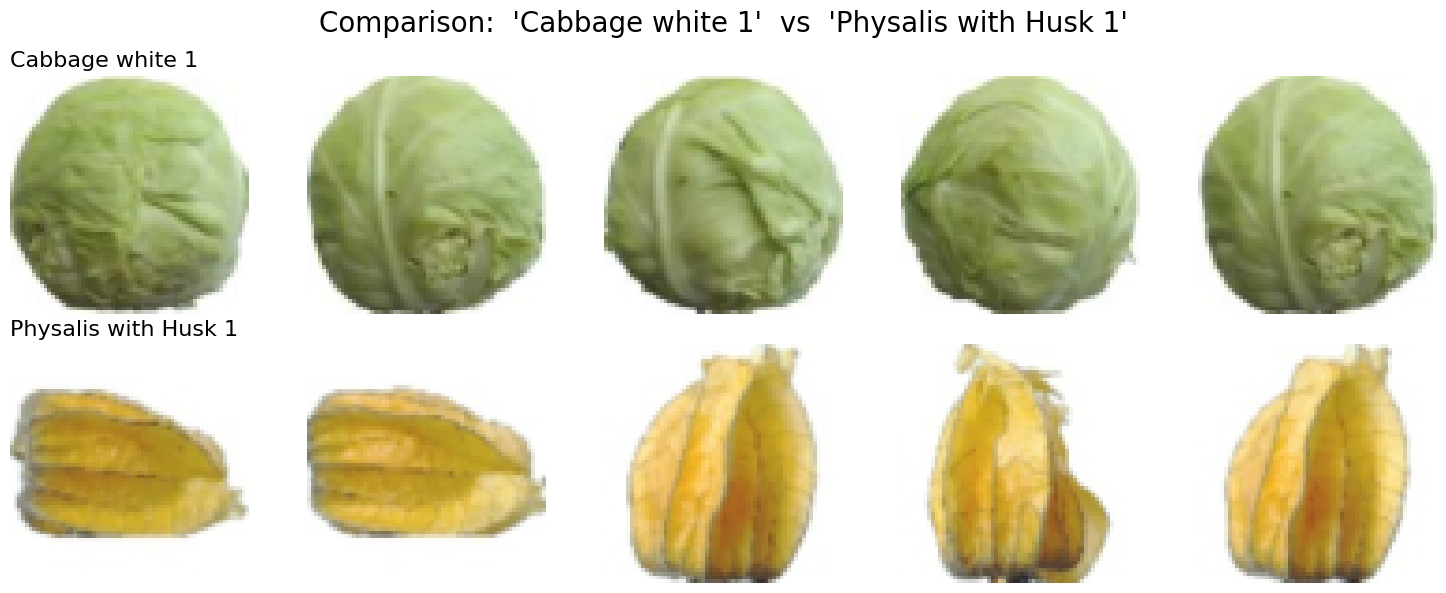

In [213]:
class1 = "Cabbage white 1"
class2 = "Apple 6"
class3 = "Physalis with Husk 1"

avg_samples = 0
# Count # of samples for each class
for class_idx, count in balanced_counts.items():
    class_name = idx_to_class[class_idx]
    avg_samples += count
    if class_name in [class1, class2, class3]:
        print(f"Class: ({class_idx:003}) {idx_to_class[class_idx].ljust(20)}  - Original Samples: {class_counts[class_idx]} - Balanced Samples: {count}")

print(f"Avg # of Samples: {(avg_samples//num_classes):003}")


plot_class_comparison(train_loader_WRS, class_to_idx, class1, class2, num_samples=5)
plot_class_comparison(train_loader_WRS, class_to_idx, class1, class3, num_samples=5)

### Compare Class Balanced Accuracy and Counts

In [215]:
def get_per_class_acc(cm):
    correct_preds = np.diag(cm)
    total_preds = cm.sum(axis=1)
    per_class_accuracy = correct_preds / total_preds
    accuracy_text = [f"{acc:.2%}" for acc in per_class_accuracy]
    return accuracy_text
    print(accuracy_text)


baseline_acc = dict(zip(class_names, get_per_class_acc(cm_baseline)))
balanced_acc = dict(zip(class_names, get_per_class_acc(cm_balanced)))
baseline_counts_dict = {class_names[k]:v for k,v in class_counts.items()}
balanced_counts_dict = {class_names[k]:v for k,v in balanced_counts.items()}
df = pd.DataFrame({
    'Baseline': baseline_acc,
    'Balanced': balanced_acc,
    'Baseline Cnts' : baseline_counts_dict,
    'Balanced Cnts' : balanced_counts_dict,
})
df.to_csv('class_balanced.csv')

In [212]:
loaded_results["test_acc"][-1],loaded_results_wrs["test_acc"][-1]

(0.1398425308554405, 0.14051638530287985)

In [222]:
df_filtered = df[df.index.isin([class1, class2, class3])]


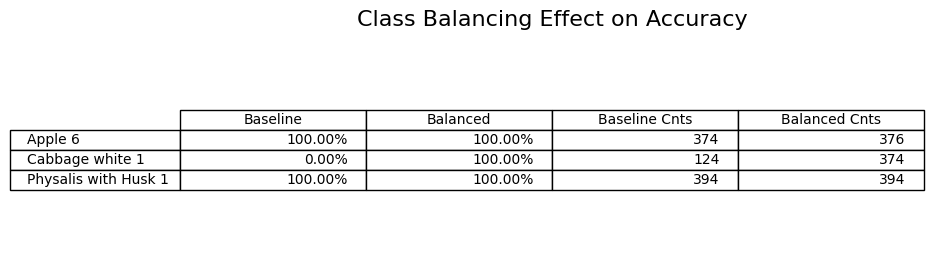

In [ ]:
# Create a table plot
fig, ax = plt.subplots(figsize=(8,2))
ax.axis("tight")
ax.axis("off")
tbl = pd.plotting.table(ax, df_filtered, loc="center", colWidths=[0.2] * len(df_filtered.columns))
ax.set_title("Class Balancing Effect on Accuracy", fontsize=16)
tbl.scale(1.2, 1.2)

# Save as image
# plt.savefig(f"{model_name}.png", dpi=300, bbox_inches="tight")
# print(f"Summary saved as {model_name}.png")